# Predicting popularity and audience engagement in TED talks based on language usage

### The goals of the project
What contributes to the broad appeal of a TED talk? Is it the speakers's upbeat and positive energy that captures the audience's attention, or does a rich and profound vocabulary play a crucial role? While we all have our personal assumptions and preferences regarding the factors that make a talk successful and beloved, this project delves into the linguistic aspects present in the transcripts to unravel the nuances that contribute to a talk's impact and resonance.

The primary objective of this project is to explore how various elements of a TED talk, including vocabulary diversity, distinctiveness, emotion, and syntax, relate to user engagement. The goal is to develop models using different textual representations and identify which features are predictive of popularity and engagement - the characteristics that keep people listening.


### Approaches and baselines

Two main approaches for predicting popularity and engagement are:
1. Classical Machine Learning Models: This approach relies on linguistic features extracted from the transcripts, employing traditional machine learning models to make predictions.

2. Pre-trained BERT Model: The second approach involves utilizing a pre-trained BERT model for predictions based on the content of the transcripts leveraging the power of contextualized language representations to enhance predictive accuracy.


This project draws inspiration from a 2021 [paper](https://aclanthology.org/2021.acl-long.52.pdf), where the authors employed various classifiers, including logistic regression with different content representations and two neural classifiers—a single-hidden-layer feedforward neural network and the pre-trained BERT model. The focus was on predicting listener engagement in both Spotify podcasts and TED talks. The aim of this project is not only to replicate but also to surpass the best performances reported in the paper by leveraging the advancements in state-of-the-art language models.

In the original paper, the highest accuracy achieved for predicting engagement in TED talks using linguistic features and a logistic regression model was 71.15%. Furthermore, the best overall accuracy, reaching 71.92%, was attained with the utilization of pre-trained BERT. This project aims to push beyond these benchmarks by leveraging the latest advancements in language model technologies.

In [19]:
import pandas as pd
import numpy as np
from google.colab import drive

drive.mount('/content/drive')

# load dataset
ted_main = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ted_main.csv')
transcripts = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/transcripts.csv')

# print dimensions of datasets
print(ted_main.shape)
print(transcripts.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(2550, 17)
(2467, 2)


The main dataset contains metadata about TED Talks on the TED.com website until September 21st, 2017, while the transcripts for the talks are availabe in the transcripts dataset.

The next step is merging of the two datasets based on the url of the talk.
Looking into the dimensions of the two datasets, we can see that not all of the datasets have a corresponding transcript.

In [2]:
# merge df and transcripts
df = pd.merge(ted_main, transcripts, on='url', how='left')

# check if any transcripts are missing
print(len(df[df.transcript.isnull()]))

86


There are 86 talks without a transcript. Since we are interested in the correlation of the talk's popularity and its linguistic features extracted from the transcript, we are going to remove the talks with missing transcripts.

In [3]:
# drop rows with missing transcripts
df = df.dropna(subset=['transcript'])
df.reset_index(drop=True, inplace=True)

In [4]:
# check the shape of the dataset
print(df.shape)
df.head()

(2467, 18)


,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,transcript
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,Good morning. How are you?(Laughter)It's been ...
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,"Thank you so much, Chris. And it's truly a gre..."
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,"(Music: ""The Sound of Silence,"" Simon & Garfun..."
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,If you're here today — and I'm very happy that...
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,"About 10 years ago, I took on the task to teac..."


### Features Available
- name: The official name of the TED Talk, includes the title and the speaker
- title: The title of the talk
- description: A blurb of what the talk is about.
- main_speaker: The first named speaker of the talk.
- speaker_occupation: The occupation of the main speaker.
- num_speaker: The number of speakers in the talk.
- duration: The duration of the talk in seconds.
- event: The TED/TEDx event where the talk took place.
- film_date: The Unix timestamp of the filming.
- published_date: The Unix timestamp for the publication of the talk on TED.com
- comments: The number of first level comments made on the talk.
- tags: The themes associated with the talk.
- languages: The number of languages in which the talk is available.
- ratings: A stringified dictionary of the various ratings given to the talk (inspiring,   fascinating, jaw dropping, etc.)
- related_talks: A list of dictionaries of recommended talks to watch next.
- url: The URL of the talk.
- views: The number of views on the talk.
- transcript: Transcript of the given talk.

In order to obtain more readable dates, we convert Unix timestamps into datetime format, keeping just the date.

In [5]:
# convert film_date and published_date to datetime
df['film_datetime'] = pd.to_datetime(df['film_date'], unit='s').dt.date
df['published_datetime'] = pd.to_datetime(df['published_date'], unit='s').dt.date

print(df[['film_datetime', 'published_datetime']].head())

  film_datetime published_datetime
0    2006-02-25         2006-06-27
1    2006-02-25         2006-06-27
2    2006-02-24         2006-06-27
3    2006-02-26         2006-06-27
4    2006-02-22         2006-06-27


We modify the dataset creating columns for each rating category containing the count of votes for the given category.

In [6]:
import ast

# convert ratings from string to list
df['ratings'] = df['ratings'].apply(lambda x: ast.literal_eval(x))
ratings = {}

# make a column for each rating based on its name
for index, row in df.iterrows():
    for i in row['ratings']:
        df.loc[index, i['name']] = i['count']
        if i['name'] in ratings:
          ratings[i['name']] += i['count']
        else:
          ratings[i['name']] = i['count']

# fill in missing values with 0
df = df.fillna(0)
df.drop('ratings', axis=1, inplace=True)

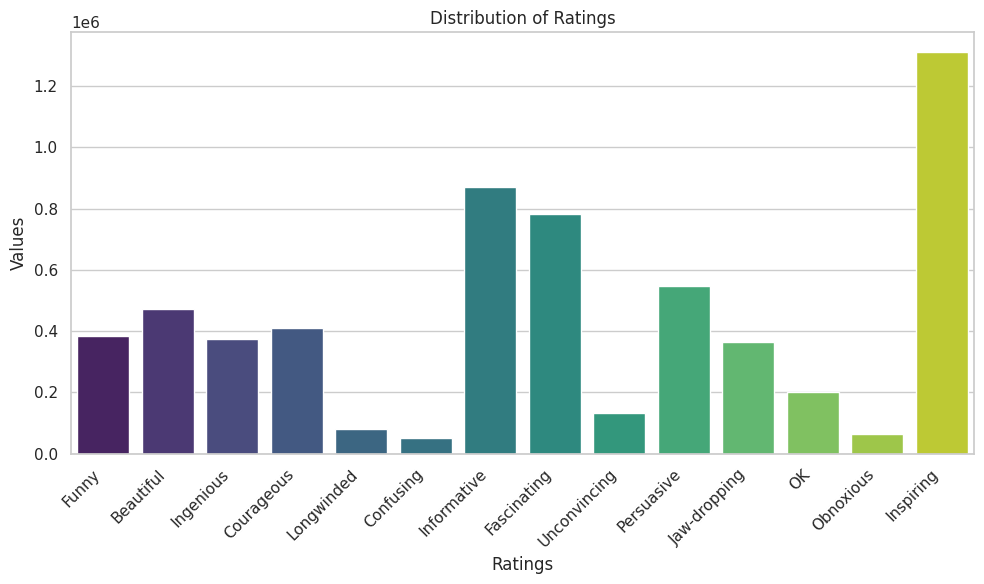

In [11]:
# plot the distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=list(ratings.keys()), y=list(ratings.values()), palette="viridis")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
plt.xlabel('Ratings')
plt.ylabel('Values')
plt.title('Distribution of Ratings')
plt.tight_layout()
plt.show()

Let's look into the distribution of tags.

In [12]:
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x))

# count distinct tags
tag_list = []
for tag in df['tags']:
    tag_list.extend(tag)
tag_list = list(set(tag_list))
print(len(tag_list))

416


In order to summarize the tags, we count the frequency of all distinct tags, and keep only the most frequent one for each talk.

In [13]:
# count the number of talks each tag appears in
tag_appearances = {}
for tag in tag_list:
    tag_appearances[tag] = 0
for tag in tag_list:
    for talk_tags in df['tags']:
        if tag in talk_tags:
            tag_appearances[tag] += 1

tag_appearances = pd.DataFrame.from_dict(tag_appearances, orient='index', columns=['count'])
tag_appearances.sort_values(by='count', ascending=False, inplace=True)
tag_appearances.head(15)

,count
technology,712
science,548
global issues,490
culture,476
TEDx,418
design,408
business,338
entertainment,287
health,234
innovation,224


In [14]:
# for each talk keep only the most frequent tag based on tag_appearances
for index, row in df.iterrows():
    max_count = 0
    max_tag = ""
    for tag in row['tags']:
        if tag_appearances.loc[tag, 'count'] > max_count:
            max_count = tag_appearances.loc[tag, 'count']
            max_tag = tag
    df.loc[index, 'tags'] = max_tag

df['tags'].head()

0          culture
1       technology
2       technology
3         business
4    global issues
Name: tags, dtype: object

In [15]:
# count the number of distinct tags
print(len(set(df['tags'])))

67


In [16]:
# encode tags as integers
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['tags'] = le.fit_transform(df['tags'])

After encoding the tags, we also encode the event names.

In [17]:
# check distribution of events
print(df['event'].value_counts())

# encode events as integers
df['event'] = le.fit_transform(df['event'])

TED2014                  84
TED2009                  81
TED2013                  77
TED2016                  75
TED2015                  75
                         ..
TEDxJaffa 2012            1
TEDxHampshireCollege      1
TEDxGoodenoughCollege     1
TEDxGlasgow               1
TEDxZurich                1
Name: event, Length: 320, dtype: int64


In [18]:
# create columns containing month and year
df['month'] = pd.DatetimeIndex(df['film_datetime']).month
df['year'] = pd.DatetimeIndex(df['film_datetime']).year

## Data exploration

In order to get a better understanding of the dataset, we continue with a deeper exploration of the features and the dataset.


## Measures of popularity
### 1. Number of views - and how are they actually counted?

Using "views" as an approximation of popularity implies that the number of people who have viewed the talk is a reasonable indicator of how popular the talk is. A positive correlation supports this assumption, indicating that talks with higher views tend to be perceived as more popular.

Each time a viewer plays a video on their device and watches for at least 30 seconds - it is counted as a view.

In [19]:
# print the titles of the most and least viewed talks
print("Top 10 most popular talks by views:\n", df[['name', 'views']].sort_values('views', ascending=False).head(10))
print("\nTop 10 talks least popular talks by views:\n", df[['name', 'views']].sort_values('views').head(10))

Top 10 most popular talks by views:
                                                    name     views
0             Ken Robinson: Do schools kill creativity?  47227110
1268  Amy Cuddy: Your body language may shape who yo...  43155405
649       Simon Sinek: How great leaders inspire action  34309432
800             Brené Brown: The power of vulnerability  31168150
444   Mary Roach: 10 things you didn't know about or...  22270883
1695  Julian Treasure: How to speak so that people w...  21594632
198             Jill Bolte Taylor: My stroke of insight  21190883
5                    Tony Robbins: Why we do what we do  20685401
2033  James Veitch: This is what happens when you re...  20475972
1338  Cameron Russell: Looks aren't everything. Beli...  19787465

Top 10 talks least popular talks by views:
                                                    name   views
1063   Bilal Bomani: Plant fuels that could power a jet  155895
1175      David Birch: A new way to stop identity theft  174326


On the first glance of the titles of the most and least popular talks, it is noticable that the talks that attract the most views are the ones on relevant topics, catchy titles, and a wider target audience unlike the lower-viewed talks with specific or niche topics, less widespread appeal and possibly less prominent speakers.

<Figure size 1000x600 with 0 Axes>

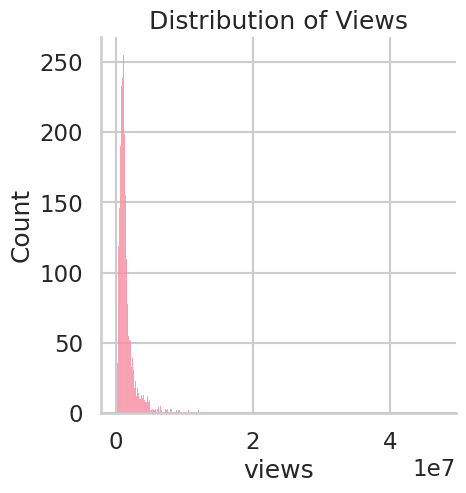

count    2.467000e+03
mean     1.740295e+06
std      2.527086e+06
min      1.558950e+05
25%      7.875785e+05
50%      1.149090e+06
75%      1.736256e+06
max      4.722711e+07
Name: views, dtype: float64

In [20]:
# plot the distribution of the number of views
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.figure(figsize=(10, 6))
sns.set_context('talk')
sns.displot(df['views'])
plt.title('Distribution of Views')
plt.show()

df['views'].describe()

The number of views range from 50k to 47 million with an average of 1.7 million views per talk.
The distribution is skewed, majority of the talks have a low number of views with a very few instances having a high number of views.

We label the top 25% of talks based on the number of views as popular.

In [21]:
# mark talks in the last quartile as popular
df['popular'] = np.where(df['views'] >= 1.736256e+06, 1, 0)
df['popular'].value_counts()

0    1850
1     617
Name: popular, dtype: int64

### 2. Number of comments

The number of comments reflects the level of engagement and interaction with the talk. A higher number of comments generally indicates that the content has sparked interest and has prompted viewers to share their thoughts, opinions, or questions, or it may have triggered discussions within online communities.

In [22]:
# print the titles of the most and least viewed talks
print("Top 10 talks by the number of comments:\n", df[['name', 'comments']].sort_values('comments', ascending=False).head(10))
print("\nTop 10 talks by the number of comments:\n", df[['name', 'comments']].sort_values('comments').head(10))

Top 10 talks by the number of comments:
                                                    name  comments
95                    Richard Dawkins: Militant atheism      6404
0             Ken Robinson: Do schools kill creativity?      4553
619      Sam Harris: Science can answer moral questions      3356
198             Jill Bolte Taylor: My stroke of insight      2877
1706  David Chalmers: How do you explain consciousness?      2673
915        Janet Echelman: Taking imagination seriously      2492
803               Lesley Hazleton: On reading the Koran      2374
1268  Amy Cuddy: Your body language may shape who yo...      2290
634       Michael Specter: The danger of science denial      2272
649       Simon Sinek: How great leaders inspire action      1930

Top 10 talks by the number of comments:
                                                    name  comments
2451  Benjamin Grant: What it feels like to see Eart...         2
2418  Françoise Mouly: The stories behind The New Yo...    

<Figure size 1000x600 with 0 Axes>

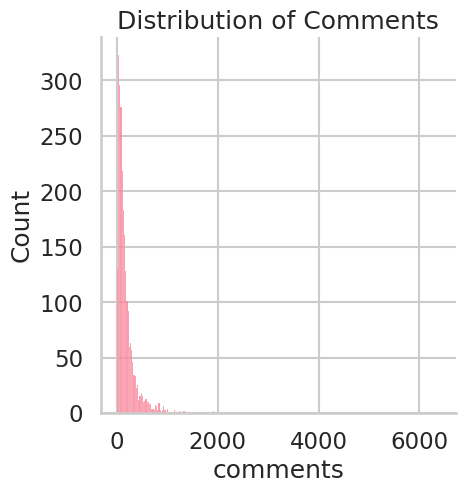

count    2467.000000
mean      192.570734
std       284.829983
min         2.000000
25%        63.000000
50%       117.000000
75%       222.500000
max      6404.000000
Name: comments, dtype: float64

In [23]:
# plot the distribution of the number of views
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.figure(figsize=(10, 6))
sns.set_context('talk')
sns.displot(df['comments'])
plt.title('Distribution of Comments')
plt.show()

df['comments'].describe()

The number of comments per talk ranges from 2 to 6404, with an average of 192 comments. Again, the distribution is skewed, having a lot of talks with very few comments, which could be correlated with their low view count, or recent posting date.

After looking into the distributions, let's see if we can observe any correlation between the number of views and comments. Are the videos with more views more likely to get more comments by  attracting a larger audience, resulting in increased opportunities for viewers to leave comments?

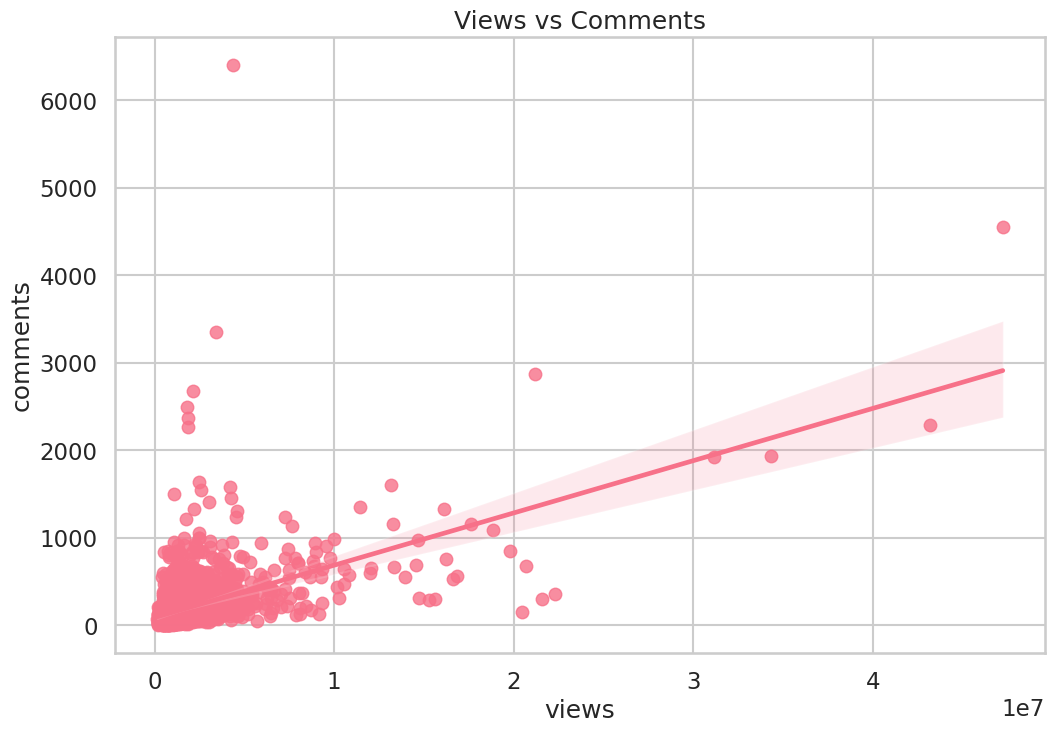

             views  comments
views     1.000000  0.530383
comments  0.530383  1.000000


In [113]:
# plot correlation between views and comments
plt.figure(figsize=(12, 8))
sns.set_context('talk')
sns.regplot(x='views', y='comments', data=df)
plt.title('Views vs Comments')
plt.show()

print(df[['views', 'comments']].corr())

A positive correlation between the two variables is observed, a value of 0.53 suggests that there is a moderate tendency for talks with more views to also have more comments. However, the relationship is not perfect, and there are likely other factors influencing the number of comments.
It is important to say that it is not necesarily the number of views that causes the high engagement, but could also be the controversy of the topic, speakers that actively encourage viewers to engage, content of other comments, etc.

### 3. Engagement rate

In order to measure engagement rate of a talk, we define an engagement coefficient by dividing the number of comments for a given talk by its corresponding number of views. This metric provides insights into the interactivity and participation of the audience in response to the content.

In [114]:
df['engagement_rate'] = df['comments'] / df['views']

# print the top 10 talks by engagement rate
print("Top 10 talks by engagement rate:\n", df[['name', 'engagement_rate', 'views', 'tags']].sort_values('engagement_rate', ascending=False).head(10))

print(df['engagement_rate'].describe())

Top 10 talks by engagement rate:
                                                    name  engagement_rate  \
767               David Bismark: E-voting without fraud         0.001534   
95                    Richard Dawkins: Militant atheism         0.001464   
665   Sharmeen Obaid-Chinoy: Inside a school for sui...         0.001421   
915        Janet Echelman: Taking imagination seriously         0.001360   
803               Lesley Hazleton: On reading the Koran         0.001285   
839     Elizabeth Lindsey: Curating humanity's heritage         0.001264   
1706  David Chalmers: How do you explain consciousness?         0.001236   
634       Michael Specter: The danger of science denial         0.001236   
550         Mallika Sarabhai: Dance to change the world         0.001235   
1175      David Birch: A new way to stop identity theft         0.001193   

        views  tags  
767    543551    60  
95    4374792    55  
665   1057238    18  
915   1832930    60  
803   1847256    29

In [115]:
# mark talks in the last quartile as engaging
df['engaging'] = np.where(df['engagement_rate'] >= 0.000168, 1, 0)
df['engaging'].value_counts()

0    1853
1     614
Name: engaging, dtype: int64

## Linguistic features

We define a set of explainable linguistic features that are hypothesized to affect popularity and engagement. These features have been drawn from different linguistic research papers, alongside own intuition.

- Faithfulness to the Title - Assessing the alignment between a talk's content and its title. This involves measuring the similarity between the title and the initial segment (first 30s) of the video using cosine similarity based on TF-IDF bag-of-words representation.

- Distinctiveness - Exploring the distinctiveness of language usage in talks, aiming to identify linguistic features that set certain talks apart and contribute to their uniqueness.

- Reading Grade Level - Analyzing the complexity of language by determining the reading grade level. This metric provides insights into the accessibility and comprehensibility of talks for a diverse audience.

- Vocabulary Diversity - Examining the diversity of vocabulary used in talks to understand how linguistic richness contributes to audience engagement and overall talk popularity.

- Sentiment/Emotion - Investigating the sentiment or emotion conveyed in talks based on the assigned ratings. Understanding the emotional tone of a talk can provide insights into its impact on the audience.

The project aims to compare the effectiveness of modeling popularity/engagement with traditional linguistic analyses against using pretrained Language Models (LLMs) with talk transcripts as inputs and the popularity/engagement rate as outputs. This comparative analysis will help evaluate the predictive power and interpretability of different modeling approaches in understanding the factors influencing talk popularity.

### 1. Determining faithfulness to the title

Each time a viewer intentionally initiates the playing of a video on their device and watches for at least 30 seconds that counts as a view.

We want to determine the faithfulness of the title to the talk during the first 30 seconds, to determine if that makes an influence on the number of views of the talk.


Since we have a transcript of a talk but not the timestamps, we can estimate the first 30 seconds based on word count. For each speech, we count the words in the transcript and divide it with the duration of the talk in order to calculate the average word count per minute per talk. Then, using this estimate, we extract the transcript during the first 30 seconds.

In [116]:
# count the number of words per transcript
df['num_words'] = df['transcript'].str.split().str.len()

# calculate the average number of words per second
df['words_per_sec'] = df['num_words'] / df['duration']

In [117]:
# using the words per second rate, concatenate the the transcript using just the first 30 seconds
df['transcript_30s'] = df.apply(lambda row: ' '.join(row['transcript'].split()[:int(row['words_per_sec']) * 30]), axis=1)
print(df['transcript_30s'].head())

0    Good morning. How are you?(Laughter)It's been ...
1    Thank you so much, Chris. And it's truly a gre...
2    (Music: "The Sound of Silence," Simon & Garfun...
3    If you're here today — and I'm very happy that...
4    About 10 years ago, I took on the task to teac...
Name: transcript_30s, dtype: object


Now based on the first 30 seconds of the talk, we calculate the cosine similarity between the TF-IDF bag of words representation of both texts.

In [118]:
# calculate TF-IDF for the first 30 seconds of the transcript and title
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# use the 30 second transcript and title as the documents
tfidf_matrix_transcript = tfidf_vectorizer.fit_transform(df['transcript_30s'])
# calculate TF-IDF for the title
tfidf_matrix_title = tfidf_vectorizer.transform(df['title'])

# Step 3: Cosine Similarity Calculation
cosine_similarities = cosine_similarity(tfidf_matrix_title, tfidf_matrix_transcript)

# use the diagonal of the cosine similarity matrix to get the similarity score
df['similarity_score'] = np.diag(cosine_similarities)
print(df['similarity_score'].head())


0    0.133536
1    0.000000
2    0.000000
3    0.000000
4    0.000000
Name: similarity_score, dtype: float64


#### Interpretation of the cos similarities

The cosine similarity score ranges from -1 to 1 and is a measure of similarity between two vectors.
In the context of text similarity, a cosine similarity score of 1 means that the two pieces of text are very similar or contain the same set of words, while a cosine similarity score of 0 suggests that the vectors are orthogonal to each other. In the context of text, it means that the two pieces of text are dissimilar or share no common words.

For a sanity check, we display examples where the title is similar to the transcript and where it is not.

In [119]:
# print the most similar transcript and its title and similarity score
print("The most similar transcripts: \n", df[['title', 'transcript_30s', 'similarity_score']].sort_values(by='similarity_score', ascending=False).head(3))

# print the least similar transcript and its title and similarity score
print("\nThe least similar transcripts: \n", df[['title', 'transcript_30s', 'similarity_score']].sort_values(by='similarity_score', ascending=True).head(3))

The most similar transcripts: 
                                       title  \
1064                   Is there a real you?   
1155     404, the story of a page not found   
944   Embracing otherness, embracing myself   

                                         transcript_30s  similarity_score  
1064  Is there a real you? This might seem to you li...          0.828061  
1155  So what I want to try to do is tell a quick st...          0.778979  
944   Embracing otherness. When I first heard this t...          0.743170  

The least similar transcripts: 
                                                   title  \
1233           A test for Parkinson's with a phone call   
1108  Religion, evolution, and the ecstasy of self-t...   
1107  Religion, evolution, and the ecstasy of self-t...   

                                         transcript_30s  similarity_score  
1233  So, well, I do applied math, and this is a pec...               0.0  
1108  I have a question for you: Are you religious? 

The examples with the highest similarity are the ones where the speakers repeat the exact words of the title during the first 30 seconts of the talk.

### Determining distinctiveness

Distinctiveness refers to a measure of how unique or perplexing a given text is. Perplexity is a measure of how well a probability distribution or probability model predicts a sample. In the context of language models, perplexity measures how well a language model predicts a given sequence of words, higher perplexity score indicting that the text is more surprising or less predictable according to the trained unigram language model.

The autors of the paper "Modeling Language Usage and Listener Engagement in Podcasts" define distinctiveness as the perplexity of the given text under a unigram language model trained over all the transcripts in the dataset. To control for length, they follow the protocol in Zhang etal.(2019) of randomly sampling a constant number of words from each text and taking the mean cross entropy over a few samples.
Taking the mean cross entropy over multiple samples helps smooth out variations that might occur due to randomness in the sampling process. It provides a more robust estimate of how well the unigram model generalizes to different subsets within a text.

The mean cross entropy is inversely related to the model's performance. A lower mean cross entropy indicates better generalization and, therefore, higher distinctiveness. On the other hand, a higher mean cross entropy suggests that the model is less effective at predicting the sampled words, indicating lower distinctiveness.

In [120]:
import random
import nltk
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

nltk.download('punkt')  # Download the punkt tokenizer

# Create a count vectorizer object
count_vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the count vectorizer using the text data
word_counts = count_vectorizer.fit_transform(df['transcript'])

# Collect the vocabulary items and their counts
vocab = count_vectorizer.get_feature_names_out()
count = word_counts.sum(axis=0).A1

# Calculate probability scores for each word
total_word_count = count.sum()
probabilities = count / total_word_count

# Create a DataFrame for vocabulary and probabilities
probability_score = pd.DataFrame({'word': vocab, 'prob': probabilities})

# Create a dictionary for faster lookups
word_prob_dict = dict(zip(probability_score['word'], probability_score['prob']))

# Function to calculate perplexity on a subset of words
def calculate_perplexity_subset(transcript, word_probabilities, subset_size=5, num_samples=3):
    transcript_words = nltk.word_tokenize(transcript.lower())
    subset_words = [random.sample(transcript_words, min(subset_size, len(transcript_words))) for _ in range(num_samples)]

    mean_cross_entropy = np.mean([
        np.sum([-np.log2(word_probabilities.get(word, 1e-10)) for word in subset]) / len(subset)
        for subset in subset_words
    ])

    return mean_cross_entropy

# Calculate distinctiveness for each transcript
df['distinctiveness'] = df['transcript'].apply(lambda x: calculate_perplexity_subset(x, word_prob_dict))

print(df['distinctiveness'].head())


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    25.789562
1    30.594576
2    25.765367
3    25.939685
4    25.944058
Name: distinctiveness, dtype: float64


### Determining reading grade level

In order to determine reading grade level, we use Flesch-Kincaid and Dale-Chall grade levels.
The Flesch-Kincaid grade level measures the number of syllables per word and the number of words per sentence, and the Dale-Chall grade level measures word 'difficulty' using a lookup table. While caution must be taken on interpreting reading grade level for transcribed speech, these measures have been explored for speech in prior work.

Lower grade levels indicate easier readability, while higher grade levels suggest more complex language. Adjustments to the text, such as removing punctuation or excluding certain words, may also influence the readability scores.

In [121]:
!pip install textstat

In [122]:
import textstat

# Calculate Flesch-Kincaid Grade Level for each transcript
df['flesch_kincaid_grade_level'] = df['transcript'].apply(lambda x: textstat.flesch_kincaid_grade(x))
print(df['flesch_kincaid_grade_level'].head())

# Calculate Dale-Chall Grade Level for each transcript
df['dale_chall_grade_level'] = df['transcript'].apply(lambda x: textstat.dale_chall_readability_score(x))
print(df['dale_chall_grade_level'].head())

0    5.7
1    6.5
2    4.2
3    8.4
4    4.6
Name: flesch_kincaid_grade_level, dtype: float64
0    6.34
1    7.12
2    6.52
3    7.70
4    6.18
Name: dale_chall_grade_level, dtype: float64


In [123]:
# transcript with the highest and lowest grade levels
print("Highest grade levels:\n", df[['title', 'transcript', 'flesch_kincaid_grade_level']].sort_values(by='flesch_kincaid_grade_level', ascending=False).head(1))
print(df[['title', 'transcript', 'dale_chall_grade_level']].sort_values(by='dale_chall_grade_level', ascending=False).head(1))

print("\nLowest grade levels:\n", df[['title', 'transcript', 'flesch_kincaid_grade_level']].sort_values(by='flesch_kincaid_grade_level').head(1))
print(df[['title', 'transcript', 'dale_chall_grade_level']].sort_values(by='dale_chall_grade_level').head(1))

Highest grade levels:
                    title                                         transcript  \
1173  Dancing with light  (Music)(Applause)(Music)(Applause)(Music)(Appl...   

      flesch_kincaid_grade_level  
1173                       220.8  
                                            title  \
2301  An electrifying acoustic guitar performance   

                                             transcript  \
2301  (Guitar music starts)(Cheers)(Cheers)(Music ends)   

      dale_chall_grade_level  
2301                   19.62  

Lowest grade levels:
                       title  \
1631  It's TED, the Musical   

                                             transcript  \
1631  Daffodil Hudson: Hello? Yeah, this is she. Wha...   

      flesch_kincaid_grade_level  
1631                         1.5  
                                title  \
270  Close-up card magic with a twist   

                                            transcript  dale_chall_grade_level  
270  My favorite topi

### Vocabulary Diversity
We examine whether speakers of more popular talks use more diverse vocabularies, quantified by the entropy of the unigram words in the text, motivated by advice to avoid word repetition.

We examine the diversity of vocabulary in a text using the entropy of unigram words. Entropy is a measure of uncertainty or disorder in a set, and in this context, it can be used to quantify the diversity of words in a text.


In [124]:
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
import math

nltk.download('punkt')  # Download the punkt tokenizer

def calculate_entropy(text):
    words = word_tokenize(text.lower())
    word_counts = Counter(words)
    total_words = len(words)

    # Calculate word probabilities
    word_probabilities = {word: count / total_words for word, count in word_counts.items()}

    # Calculate entropy
    entropy = -sum(prob * math.log2(prob) for prob in word_probabilities.values())

    return entropy

df['vocabulary_diversity'] = df['transcript'].apply(lambda x: calculate_entropy(x))
print(df['vocabulary_diversity'].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0    7.813619
1    7.894040
2    7.991748
3    8.481292
4    7.717105
Name: vocabulary_diversity, dtype: float64


In [125]:
# transcript with the highest and lowest vocabulary diversity
print("Highest vocabulary diversity:\n", df[['title', 'transcript', 'vocabulary_diversity']].sort_values(by='vocabulary_diversity', ascending=False).head(1))
print("\nLowest vocabulary diversity:\n", df[['title', 'transcript', 'vocabulary_diversity']].sort_values(by='vocabulary_diversity').head(1))

Highest vocabulary diversity:
                           title  \
1146  A 40-year plan for energy   

                                             transcript  vocabulary_diversity  
1146  America's public energy conversation boils dow...              8.608245  

Lowest vocabulary diversity:
               title                   transcript  vocabulary_diversity
146  My magic moves  (Applause)(Music)(Applause)              1.891061


### Sentiment/emotion analysis

We use the audience ratings as a measure of of sentiment of the talks.

In [126]:
# save the dataframe with linguistic features
df.to_csv('/content/drive/MyDrive/Colab Notebooks/df.csv', index=False)

In [31]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/df.csv')

In [32]:
df.columns

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'related_talks', 'speaker_occupation', 'tags', 'title', 'url', 'views',
       'transcript', 'film_datetime', 'published_datetime', 'Funny',
       'Beautiful', 'Ingenious', 'Courageous', 'Longwinded', 'Confusing',
       'Informative', 'Fascinating', 'Unconvincing', 'Persuasive',
       'Jaw-dropping', 'OK', 'Obnoxious', 'Inspiring', 'month', 'year',
       'popular', 'engagement_rate', 'engaging', 'num_words', 'words_per_sec',
       'transcript_30s', 'similarity_score', 'distinctiveness',
       'flesch_kincaid_grade_level', 'dale_chall_grade_level',
       'vocabulary_diversity'],
      dtype='object')

## Predicting popularity using only linguistic features

After defining the set of explainable linguistic features, we employ traditional ML models to predict the popularity and engagement rates.

#### Splitting the data
Once we have extracted the features, we split the data into train and test datasets.

An essential consideration during this process is the presence of imbalanced target classes within the dataset, which could potentially impact the performance of our models.

To address this imbalance, we create balanced datasets by taking a representative sample from the larger target classes, aligning their sizes with those of the smaller target classes. By doing so, we strive to mitigate the effects of class imbalance, fostering a more robust and fair learning environment for our classification models.

In [149]:
# define a dataset with the modeled linguistic features
df = df[['duration', 'event', 'film_date', 'languages', 'num_speaker',
       'tags', 'Funny', 'Beautiful', 'Ingenious', 'Courageous', 'Longwinded', 'Confusing',
       'Informative', 'Fascinating', 'Unconvincing', 'Persuasive', 'Jaw-dropping', 'OK', 'Obnoxious',
       'Inspiring', 'month', 'year', 'words_per_sec', 'similarity_score', 'distinctiveness',
       'flesch_kincaid_grade_level', 'dale_chall_grade_level', 'vocabulary_diversity', 'popular', 'engaging']]

In [33]:
from sklearn.model_selection import train_test_split

# split to test and train - unbalanced classes
train_ling, test_ling = train_test_split(df, test_size=0.2, random_state=42)
train_ling.dropna(subset=['popular'], inplace=True)
test_ling.dropna(subset=['popular'], inplace=True)

# balance the dataset by sampling equal number of engaging and non-engaging talks
df_engaging = df[df['engaging'] == 1]
df_non_engaging = df[df['engaging'] == 0].sample(n=len(df_engaging), random_state=42)
df_balanced_engaging = pd.concat([df_engaging, df_non_engaging])
df_balanced_engaging.drop(['popular'], axis=1, inplace=True)
train_engaging, test_engaging = train_test_split(df_balanced_engaging, test_size=0.2, random_state=42)

# balance the dataset by sampling equal number of popular and non-popular talks
df_popular = df[df['popular'] == 1]
df_non_popular = df[df['popular'] == 0].sample(n=len(df_popular), random_state=42)
df_balanced_popular = pd.concat([df_popular, df_non_popular])
df_balanced_popular.drop(['engaging'], axis=1, inplace=True)
train_popular, test_popular = train_test_split(df_balanced_popular, test_size=0.2, random_state=42)

### 1. Random Forest Classifier

In [155]:
from sklearn.metrics import confusion_matrix, fbeta_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def train_predict(clf, parameters, x_train, x_test, y_train, y_test):

    clf.fit(x_train, y_train)
    scorer = make_scorer(fbeta_score, beta=1)

    # 5-fold cross validation
    grid_obj = GridSearchCV(clf, parameters, cv=5, scoring=scorer)
    grid_fit = grid_obj.fit(x_train, y_train)
    best_clf = grid_fit.best_estimator_
    best_prob_train = best_clf.predict_proba(x_train)
    best_prob = best_clf.predict_proba(x_test)
    best_pred_train = (best_prob_train[:,1]>0.5)*1
    best_pred = (best_prob[:,1]>0.5)*1

    # Report results
    print (clf.__class__.__name__ + ":")
    print ("Accuracy score on training data (optimized by grid-search CV): {:.4f}".format(best_clf.score(x_train, y_train)))
    print ("Accuracy score on testing data (optimized by grid-search CV): {:.4f}".format(best_clf.score(x_test, y_test)))
    print ("F1-score on training data (optimized by grid-search CV): {:.4f}".format(fbeta_score(y_train, best_pred_train, beta = 1)))
    print ("F1-score on testing data (optimized by grid-search CV): {:.4f}".format(fbeta_score(y_test, best_pred, beta = 1)))
    print ("Parameters: ", grid_fit.best_params_)
    print ("Confusion Matrix:\n", confusion_matrix(y_test, best_pred))
    return clf

In [177]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(random_state = 108)
parameters = {'n_estimators': range(10,21,2), 'max_features': ['log2'], 'min_samples_split': range(3, 7)}

# Random Forest using linguistic features to predict popularity
print("Random forest classifier using only linguistic features to predict popularity: \n")
clf1 = train_predict(clf, parameters, train_ling.iloc[:, :-2], test_ling.iloc[:, :-2], train_ling['popular'], test_ling['popular'])

# Random Forest using linguistic features to predict engagement rate
print("\nRandom forest classifier using only linguistic features to predict engagement: \n")
clf2 = train_predict(clf, parameters, train_ling.iloc[:, :-2], test_ling.iloc[:, :-2], train_ling['engaging'], test_ling['engaging'])

# Random Forest using linguistic features to predict popularity on a balanced dataset
print("\nRandom forest classifier using only linguistic features to predict popularity on the balanced dataset: \n")
clf3 = train_predict(clf, parameters, train_popular.iloc[:, :-1], test_popular.iloc[:, :-1], train_popular['popular'], test_popular['popular'])

# Random Forest using linguistic features to predict engagement rate on a balanced dataset
print("\nRandom forest classifier using only linguistic features to predict engagement on the balanced dataset: \n")
clf4 = train_predict(clf, parameters, train_engaging.iloc[:, :-1], test_engaging.iloc[:, :-1], train_engaging['engaging'], test_engaging['engaging'])

Random forest classifier using only linguistic features to predict popularity: 

RandomForestClassifier:
Accuracy score on training data (optimized by grid-search CV): 0.9944
Accuracy score on testing data (optimized by grid-search CV): 0.9008
F1-score on training data (optimized by grid-search CV): 0.9889
F1-score on testing data (optimized by grid-search CV): 0.7721
Parameters:  {'max_features': 'log2', 'min_samples_split': 4, 'n_estimators': 20}
Confusion Matrix:
 [[362  13]
 [ 36  83]]

Random forest classifier using only linguistic features to predict engagement: 

RandomForestClassifier:
Accuracy score on training data (optimized by grid-search CV): 0.9853
Accuracy score on testing data (optimized by grid-search CV): 0.7996
F1-score on training data (optimized by grid-search CV): 0.9691
F1-score on testing data (optimized by grid-search CV): 0.5171
Parameters:  {'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 12}
Confusion Matrix:
 [[342  22]
 [ 77  53]]

Random f

For both popularity and engagement rate, random forest classifier performs quite well using only the linguistic features.

It is interesting to compare the results on the balanced vs unbalanced datasets. As assumed, if the model is trained on a highly imbalanced dataset, the model tends create a lot of false negatives, as the negative class is the dominant one. That's why F1 score is significantly higher on the balanced dataset, suggesting a balance between precision and recall.

Further on we continue the analysis using only the balanced dataset.

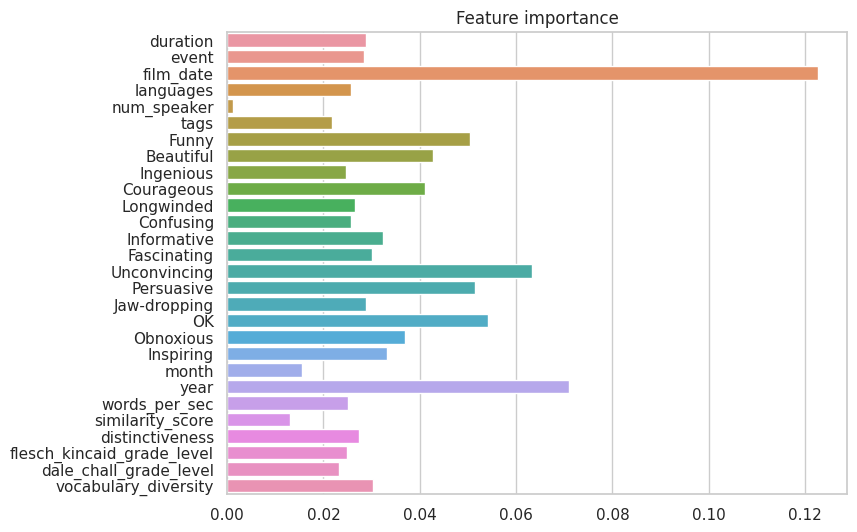

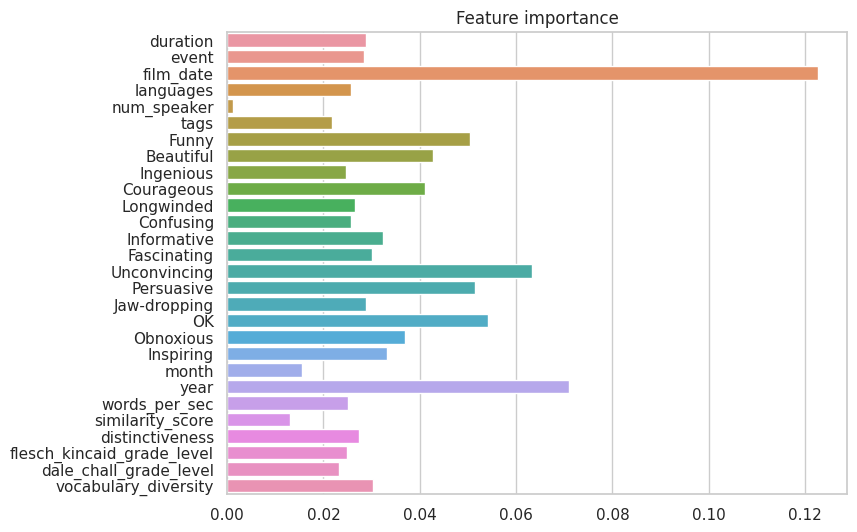

In [178]:
sns.set_style('whitegrid')
sns.set_palette('husl')
plt.figure(figsize=(8, 6))
sns.barplot(x=clf3.feature_importances_, y=test_popular.iloc[:, :-1].columns)
plt.title('Feature importance')
plt.show()

plt.figure(figsize=(8, 6))
sns.barplot(x=clf4.feature_importances_, y=test_engaging.iloc[:, :-1].columns)
plt.title('Feature importance')
plt.show()

The two plots show the feature importance for popularity/engagement prediction on the balanced dataset. film_date and year are the most significant, probably because the longer the video has been online, more likely it is that it has a lot of views and comments.
Ratings 'Funny' and 'Unconvincing' are shown to be significant for the popularity, 'Funny' is probably positively and 'Unconvincing' negatively correlated.
Number of speakers shows the least significance, probably because people are more interested in the content of the talk itself regardless of the number of speakers.

### 2. Naive Bayes

In [180]:
from sklearn.naive_bayes import GaussianNB

clf2 = GaussianNB()
parameters={}

# Naive Bayes using linguistic features to predict popularity on a balanced dataset
print("\nNaive Bayes classifier using only linguistic features to predict popularity on the balanced dataset: \n")
clf3 = train_predict(clf2, parameters, train_popular.iloc[:, :-1], test_popular.iloc[:, :-1], train_popular['popular'], test_popular['popular'])

# Naive Bayes using linguistic features to predict engagement rate on a balanced dataset
print("\nNaive Bayes classifier using only linguistic features to predict engagement on the balanced dataset: \n")
clf4 = train_predict(clf2, parameters, train_engaging.iloc[:, :-1], test_engaging.iloc[:, :-1], train_engaging['engaging'], test_engaging['engaging'])


Naive Bayes classifier using only linguistic features to predict popularity on the balanced dataset: 

GaussianNB:
Accuracy score on training data (optimized by grid-search CV): 0.5441
Accuracy score on testing data (optimized by grid-search CV): 0.5223
F1-score on training data (optimized by grid-search CV): 0.1313
F1-score on testing data (optimized by grid-search CV): 0.2133
Parameters:  {}
Confusion Matrix:
 [[113   0]
 [118  16]]

Naive Bayes classifier using only linguistic features to predict engagement on the balanced dataset: 

GaussianNB:
Accuracy score on training data (optimized by grid-search CV): 0.6701
Accuracy score on testing data (optimized by grid-search CV): 0.7520
F1-score on training data (optimized by grid-search CV): 0.7038
F1-score on testing data (optimized by grid-search CV): 0.7904
Parameters:  {}
Confusion Matrix:
 [[ 70  41]
 [ 20 115]]


### 3. K-Nearest Neighbours


In [183]:
from sklearn.neighbors import KNeighborsClassifier

clf3 = KNeighborsClassifier()
parameters = {'n_neighbors': range(1, 11)}

# KNN using linguistic features to predict popularity on a balanced dataset
print("\nKNN classifier using only linguistic features to predict popularity on the balanced dataset: \n")
clf3 = train_predict(clf3, parameters, train_popular.iloc[:, :-1], test_popular.iloc[:, :-1], train_popular['popular'], test_popular['popular'])

# KNN using linguistic features to predict engagement rate on a balanced dataset
print("\nKNN classifier using only linguistic features to predict engagement on the balanced dataset: \n")
clf4 = train_predict(clf3, parameters, train_engaging.iloc[:, :-1], test_engaging.iloc[:, :-1], train_engaging['engaging'], test_engaging['engaging'])


Logistic Regression classifier using only linguistic features to predict popularity on the balanced dataset: 

KNeighborsClassifier:
Accuracy score on training data (optimized by grid-search CV): 0.7325
Accuracy score on testing data (optimized by grid-search CV): 0.6113
F1-score on training data (optimized by grid-search CV): 0.7130
F1-score on testing data (optimized by grid-search CV): 0.6444
Parameters:  {'n_neighbors': 7}
Confusion Matrix:
 [[64 49]
 [47 87]]

Logistic Regression classifier using only linguistic features to predict engagement on the balanced dataset: 

KNeighborsClassifier:
Accuracy score on training data (optimized by grid-search CV): 0.7332
Accuracy score on testing data (optimized by grid-search CV): 0.7073
F1-score on training data (optimized by grid-search CV): 0.7369
F1-score on testing data (optimized by grid-search CV): 0.7209
Parameters:  {'n_neighbors': 9}
Confusion Matrix:
 [[81 30]
 [42 93]]


Random forest classifier outperforms Gaussian Naive Bayes and KNN with 90.08% accuracy on the complete dataset and 84.62% on the balanced dataset for popularity prediction, and 79.96% on the complete and 80.89% on the balanced dataset for engagement rate prediction.

## Predicting popularity based on transcripts using BERT

In this section, the objective is to forecast both popularity and engagement relying only on the transcripts of the talks. However, due to BERT's token length restriction set to 512, and given that our transcripts often exceed this limit, we adopted a proven approach highlighted in this [paper](https://arxiv.org/abs/1905.05583). The strategy involves cutting out the middle part of the text instead of truncating either the beginning or the end. This specific approach has demonstrated superior performance, even surpassing more complex "hierarchical" methods involving breaking the text into chunks and then recombining the results.

In [ ]:
# concatenate all the features in df and separate them with "[SEP]" except popularity, engagement, views, transcript
df_concat = df.copy()
df_concat.drop(['popular', 'engaging', 'views', 'transcript', 'url', 'description'], axis=1, inplace=True)
concatenated_features = df_concat[df_concat.columns[0:]].apply(lambda x: '[SEP] '.join(x.astype(str)), axis=1)
# concatenate the features with the transcript separated by "."
# df['transcript'] = df['transcript'].apply(lambda x: '[CLS] ' + x)
# concatenated_features = pd.concat([concatenated_features, df['transcript']], axis=1)
# concatenated_features = concatenated_features[concatenated_features.columns[0:]].apply(lambda x: '[SEP]'.join(x.astype(str)), axis=1)
concatenated_features.head()

0    4553[SEP]1164[SEP]36[SEP]1140825600[SEP]60[SEP...
1    265[SEP]977[SEP]36[SEP]1140825600[SEP]43[SEP]A...
2    124[SEP]1286[SEP]36[SEP]1140739200[SEP]26[SEP]...
3    200[SEP]1116[SEP]36[SEP]1140912000[SEP]35[SEP]...
4    593[SEP]1190[SEP]36[SEP]1140566400[SEP]48[SEP]...
dtype: object

In [42]:
# us only the middle part of each transcript
transcript_middle = df.apply(lambda row: ' '.join(row['transcript'].split()[int(len(row['transcript'].split()) / 4):int(len(row['transcript'].split()) / 4) + int(len(row['transcript'].split()) / 2)]), axis=1)

In [26]:
transcript_middle.head()

0    boy said, "I bring you myrrh." And the third b...
1    out to be, was that my staff was extremely ups...
2    typing 11?" He said, "The message says, 'Error...
3    are striving for solutions that won't compromi...
4    the life expectancy of the African countries a...
dtype: object

In [13]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
)

No GPU available, using the CPU instead.


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Tokenize all of the sentences and map the tokens to their word IDs.
import torch

input_ids = []
attention_masks = []
max_len = 512

# Larger batch sizes tend to be better, and we can fit this in memory.
batch_size = 32
learning_rate = 1e-5
epochs = 4

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# For every sentence:
for sent in transcript_middle:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = max_len,
                        truncation = True,
                        padding = 'max_length',
                        return_attention_mask = True,
                        return_tensors = 'pt')

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

labels_popular = torch.tensor(df['popular'].values)
labels_engaging = torch.tensor(df['engaging'].values)

In [8]:
import random
import numpy as np
from torch.utils.data import TensorDataset,DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup

# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - (train_size + val_size)

# Sanity check the sizes
assert((train_size + val_size + test_size) == len(df))

# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(df))

# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)


print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

# Split the samples, and create TensorDatasets for each split for both target values.
train_dataset_popular = TensorDataset(input_ids[train_idx], attention_masks[train_idx], labels_popular[train_idx])
val_dataset_popular = TensorDataset(input_ids[val_idx], attention_masks[val_idx], labels_popular[val_idx])
test_dataset_popular = TensorDataset(input_ids[test_idx], attention_masks[test_idx], labels_popular[test_idx])

train_dataset_engaging = TensorDataset(input_ids[train_idx], attention_masks[train_idx], labels_engaging[train_idx])
val_dataset_engaging = TensorDataset(input_ids[val_idx], attention_masks[val_idx], labels_engaging[val_idx])
test_dataset_engaging = TensorDataset(input_ids[test_idx], attention_masks[test_idx], labels_engaging[test_idx])

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader_popular = DataLoader(
            train_dataset_popular,
            sampler = RandomSampler(train_dataset_popular),
            batch_size = batch_size
        )
train_dataloader_engaging = DataLoader(
            train_dataset_popular,
            sampler = RandomSampler(train_dataset_engaging),
            batch_size = batch_size
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader_popular = DataLoader(
            val_dataset_popular,
            sampler = SequentialSampler(val_dataset_popular),
            batch_size = batch_size
        )
validation_dataloader_engaging = DataLoader(
            val_dataset_engaging,
            sampler = SequentialSampler(val_dataset_engaging),
            batch_size = batch_size
        )

optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = 1e-8
                )
total_steps = len(train_dataloader_popular) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

  Training size: 1,973
Validation size: 246
      Test size: 248


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
import numpy as np
import time
import datetime

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [8]:
import random
import numpy as np
from sklearn.metrics import classification_report

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# wrap the training into a function

def train_model(train_dataloader, validation_dataloader):

  # Set the seed value all over the place to make this reproducible.
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  for epoch_i in range(0, epochs):

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)

              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader.
          # `batch` contains four pytorch tensors:
          #   [0]: input ids
          #   [1]: attention masks
          #   [2]: labels_popular
          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          model.zero_grad()

          result = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels,
                        return_dict=True)

          loss = result.loss
          logits = result.logits

          # Accumulate the training loss over all of the batches
          total_train_loss += loss.item()

          # Perform a backward pass to calculate the gradients.
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)

      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently during evaluation.
      model.eval()

      # Tracking variables
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:

          b_input_ids = batch[0].to(device)
          b_input_mask = batch[1].to(device)
          b_labels = batch[2].to(device)

          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():

              # Forward pass, calculate logit predictions.
              result = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels,
                            return_dict=True)

          # Get the loss and "logits" output by the model. The "logits" are the
          # output values prior to applying an activation function like the
          # softmax.
          loss = result.loss
          logits = result.logits

          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = logits.detach().cpu().numpy()
          label_ids = b_labels.to('cpu').numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)


      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)

      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)

      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [9]:
# define a function for predicting labels

def predict(test_dataset):
  prediction_sampler = SequentialSampler(test_dataset)
  prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)

  print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))

  # Put model in evaluation mode
  model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Predict
  for batch in prediction_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions.
        result = model(b_input_ids,
                      token_type_ids=None,
                      attention_mask=b_input_mask,
                      return_dict=True)

    logits = result.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

  # Combine the results across all batches.
  flat_predictions = np.concatenate(predictions, axis=0)

  # For each sample, pick the label (0 or 1) with the higher score.
  flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

  # Combine the correct labels for each batch into a single list.
  flat_true_labels = np.concatenate(true_labels, axis=0)

  print(classification_report(flat_true_labels, flat_predictions))


In [12]:
# train model using middle part of transcripts to predict popularity
train_model(train_dataloader_popular, validation_dataloader_popular)
predict(test_dataset_popular)

# predict engagement
train_model(train_dataloader_engaging, validation_dataloader_engaging)
predict(test_dataset_engaging)


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:15:11.

  Average training loss: 0.57
  Training epcoh took: 0:23:14

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.56
  Validation took: 0:00:52

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:14:10.

  Average training loss: 0.53
  Training epcoh took: 0:21:49

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.54
  Validation took: 0:00:47

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:14:07.

  Average training loss: 0.50
  Training epcoh took: 0:21:39

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.53
  Validation took: 0:00:50

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     62.    Elapsed: 0:13:54.

  Average training loss: 0.47
  Training epcoh took: 0:21:28

Running Validation...
  Accuracy: 0.73
  Validation Loss: 0.53
  Validation took: 0:00:45

Training complete!
Total tr

#### Results

The output shows classification reports detailing predictions for popularity and engagement using only the transcripts of the talks with a pre-trained BERT model. These reports provide key metrics like precision, recall, and F1-score, offering a straightforward evaluation of the model's performance in making accurate predictions based on the talk content.

The accuracy achieved for predicting popularity trained on the entire (unbalanced) dataset is 79%. To put this into context, the best accuracy using solely linguistic features reached 90% on the complete dataset and 85% on the balanced dataset.

For engagement prediction trained on the entire (unbalanced) dataset, the accuracy stands at 63%. In comparison, the best accuracy using only linguistic features was 79% on the full dataset and 80% on the balanced dataset.

It's important to note that the BERT model underwent training for over 1.5 hours on a TPU, whereas models trained solely on linguistic features required mere seconds for label predictions using a CPU.

In [46]:
!pip install pipreqs

  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=63028e84f8f0e52ed67e82b01c6ad66b70402c3a68e2a60840ffed74ea0fe161
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [53]:
!pip freeze > requirements.txt